## Fama-French Five-Factor Model Replication Results

Min(Minna) Jiang

University of Toronto

Access WRDS

In [35]:
import wrds
conn = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


Set data range

In [106]:
startdate = '07/01/1926'
enddate = '12/31/2024'

Download Compustat

In [107]:
import pandas as pd
import numpy as np
import datetime as dt
#import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import statsmodels.api as sm

comp = conn.raw_sql(f"""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk, revt, cogs, xint, xsga
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '{startdate}'
                    """, date_cols=['datadate'])

comp['year']=comp['datadate'].dt.year
# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])
comp['txditc']=comp['txditc'].fillna(0) #deferred taxes and investment tax credit
# create book equity
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)
# create profitability
comp['profit']=(comp['revt']-comp['cogs']-comp['xint']-comp['xsga'])/comp['be']
# create inventment
comp = comp.sort_values(by=["gvkey", "year"])
comp["inv"] = comp.groupby("gvkey")["at"].shift(0) / comp.groupby("gvkey")["at"].shift(1)
# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','profit','inv','count']]

Download CRSP

In [108]:
crsp_m = conn.raw_sql(f"""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc, b.namedt, b.nameendt
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '{startdate}' and '{enddate}'
                      and b.exchcd between 1 and 3
                      """, date_cols=['date']) 

# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

#crsp_m.head()
# Line up date to be end of month
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)
#crsp_m.head()
# add delisting return
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """, date_cols=['dlstdt'])

dlret.permno=dlret.permno.astype(int)
#dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp.head()
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)

# retadj factors in the delisting returns
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

# calculate market equity
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
crsp=crsp.drop(['dlret','dlstdt','prc','shrout','namedt','nameendt'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])
### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])

# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])

# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()
# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

### July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])
# cumret by stock #production of returns for each ffyear
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()

# lag cumret #shift to the next year
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together #now every month lme is the first month me*accum ret
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

#year+1
decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]
# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun.head()
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

Download CCM and merge data

In [109]:
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

ccm1=pd.merge(comp[['gvkey','datadate','be', 'count','profit','inv']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)
# set link date bounds
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count','profit','inv']]
# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']
ccm1=pd.merge(comp[['gvkey','datadate','be', 'count','profit','inv']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)
# set link date bounds
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count','profit','inv']]

# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

Calculate NYSE breakdown

In [110]:
# select NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & \
             (ccm_jun['count']>=1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]

# size breakdown #for each year
#nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})
nyse_sz=nyse.groupby(['jdate'])['me'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_sz=nyse_sz[['jdate','30%','70%']].rename(columns={'30%':'me30', '70%':'me70'})

# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

#profitability breakdown
nyse_pro=nyse.groupby(['jdate'])['profit'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_pro=nyse_pro[['jdate','30%','70%']].rename(columns={'30%':'profit30', '70%':'profit70'})

#investment breakdown
nyse_inv=nyse.groupby(['jdate'])['inv'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_inv=nyse_inv[['jdate','30%','70%']].rename(columns={'30%':'inv30', '70%':'inv70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])
nyse_breaks = pd.merge(nyse_breaks, nyse_pro, how='inner', on=['jdate'])
nyse_breaks = pd.merge(nyse_breaks, nyse_inv, how='inner', on=['jdate'])

c:\Users\Minna\miniconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minna\miniconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Minna\miniconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Apply breakdown to classify the data

In [111]:
# join back size, beme, profit, investment breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])
# function to assign size, beme, profit, investment bucket
def sz_bucket(row):
    if 0<=row['me']<=row['me30']:
        value = 'L'
    elif row['me']<=row['me70']:
        value='M'
    elif row['me']>row['me70']:
        value='H'
    else:
        value=''
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value

def pro_bucket(row):
    if 0<=row['profit']<=row['profit30']:
        value = 'L'
    elif row['profit']<=row['profit70']:
        value='M'
    elif row['profit']>row['profit70']:
        value='H'
    else:
        value=''
    return value

def inv_bucket(row):
    if 0<=row['inv']<=row['inv30']:
        value = 'L'
    elif row['inv']<=row['inv70']:
        value='M'
    elif row['inv']>row['inv70']:
        value='H'
    else:
        value=''
    return value

# assign size portfolio
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')

# assign book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')

# assign size portfolio
ccm1_jun['proport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(pro_bucket, axis=1), '')

# assign book-to-market portfolio
ccm1_jun['invport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(inv_bucket, axis=1), '')

# create positivebmeme and nonmissport variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)
#ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!='')&(ccm1_jun['proport']!='')&(ccm1_jun['invport']!=''), 1, 0)

# store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','proport','invport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# merge back with monthly records #######we regress monthly return!
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','proport','invport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

C:\Users\Minna\AppData\Local\Temp\ipykernel_17500\1259147778.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june['ffyear']=june['jdate'].dt.year


### Form Fama French Factors and compare the results

In [112]:
# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

#### Compare Portfolios Formed on Size

C:\Users\Minna\AppData\Local\Temp\ipykernel_17500\2995093254.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwret_sz=ccm4.groupby(['jdate','szport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret_sz'})


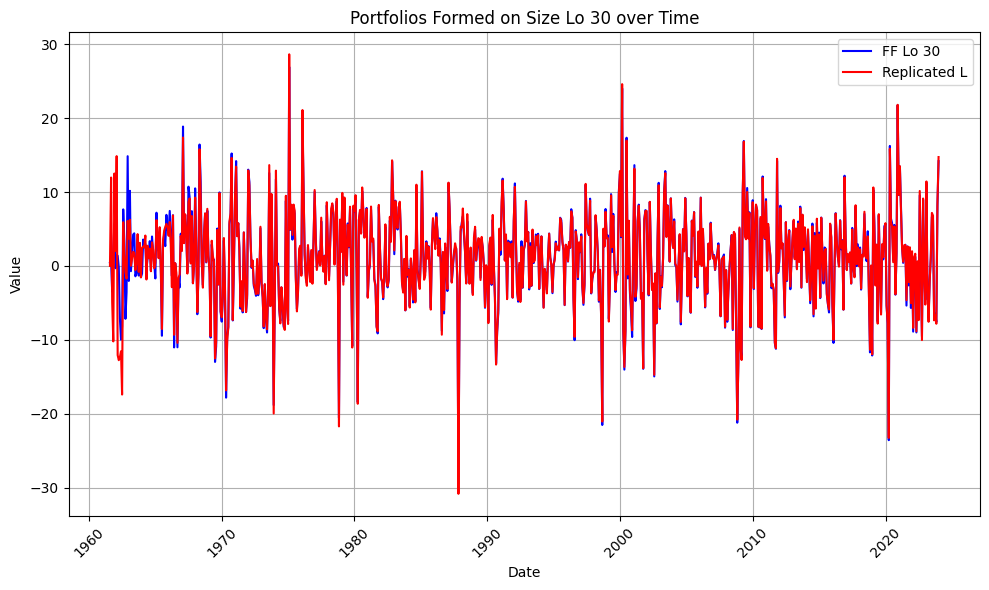

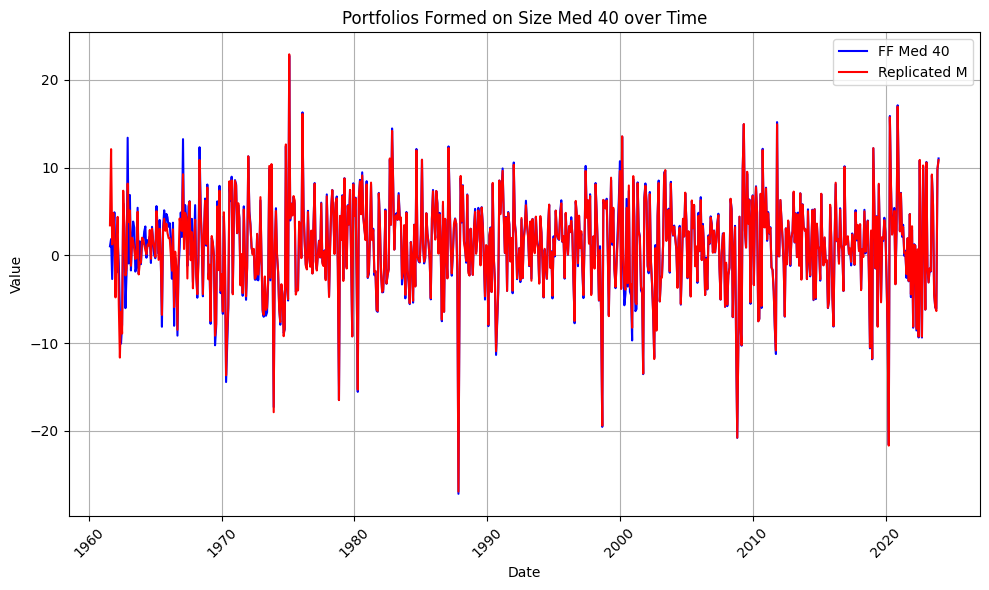

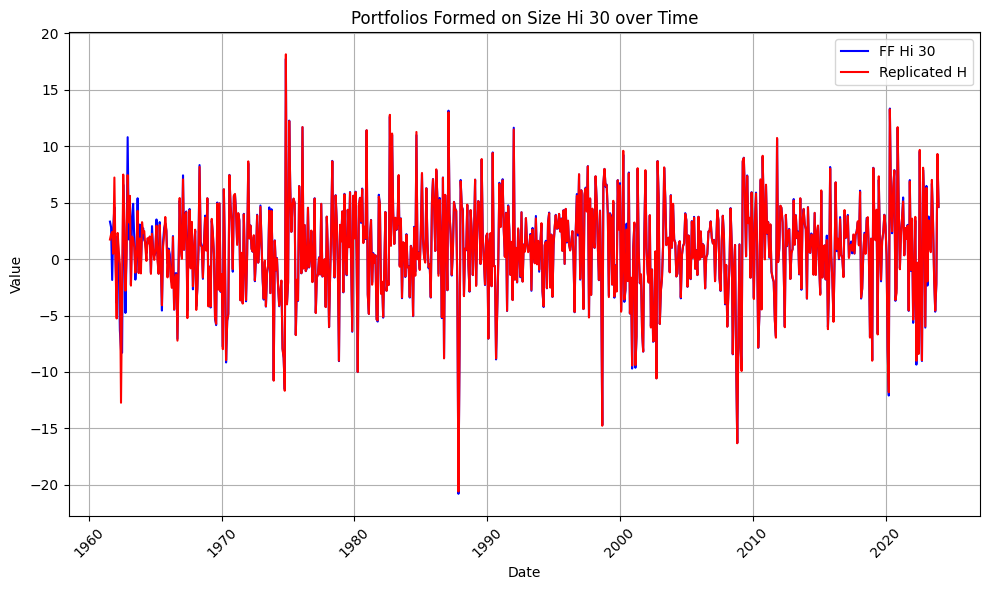

In [113]:
# value-weigthed return
vwret_sz=ccm4.groupby(['jdate','szport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret_sz'})

ff_factors_sz=vwret_sz.pivot(index='jdate', columns='szport', values='vwret_sz').reset_index()
ff_factors_sz
ff_factors_sz['year_month'] = ff_factors_sz['jdate'].dt.to_period('M')

#use data downloaded from Ken French’s website/Univariate sorts on Size, B/M, OP, and Inv/Portfolios Formed on Size/Value Weight Returns -- Monthly
df_me = pd.read_csv("Portfolios_Formed_on_ME_CSV_3.csv")

df_me['year_month'] = pd.to_datetime(df_me['year'].astype(str), format='%Y%m')
df_me['year_month'] = df_me['year_month'].dt.to_period('M')
_ffcomp_me = pd.merge(df_me, ff_factors_sz[['jdate','year_month','H','M','L']], how='inner', on=['year_month'])
_ffcomp_me['L']=_ffcomp_me['L']*100
_ffcomp_me['M']=_ffcomp_me['M']*100
_ffcomp_me['H']=_ffcomp_me['H']*100
_ffcomp_me=_ffcomp_me.dropna()

#draw the picture
plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_me['jdate'], _ffcomp_me['Lo 30'], color='blue', linestyle='-', label='FF Lo 30')
plt.plot(_ffcomp_me['jdate'], _ffcomp_me['L'], color='red', linestyle='-', label='Replicated L')
plt.title('Portfolios Formed on Size Lo 30 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_me['jdate'], _ffcomp_me['Med 40'], color='blue', linestyle='-', label='FF Med 40')
plt.plot(_ffcomp_me['jdate'], _ffcomp_me['M'], color='red', linestyle='-', label='Replicated M')
plt.title('Portfolios Formed on Size Med 40 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_me['jdate'], _ffcomp_me['Hi 30'], color='blue', linestyle='-', label='FF Hi 30')
plt.plot(_ffcomp_me['jdate'], _ffcomp_me['H'], color='red', linestyle='-', label='Replicated H')
plt.title('Portfolios Formed on Size Hi 30 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
print(stats.pearsonr(_ffcomp_me['Lo 30'], _ffcomp_me['L']))
print(stats.pearsonr(_ffcomp_me['Med 40'], _ffcomp_me['M']))
print(stats.pearsonr(_ffcomp_me['Hi 30'], _ffcomp_me['H']))

PearsonRResult(statistic=0.9779879044697285, pvalue=0.0)
PearsonRResult(statistic=0.9894445335117159, pvalue=0.0)
PearsonRResult(statistic=0.9937341001418071, pvalue=0.0)


Calculate scores

In [125]:
import pandas as pd
import numpy as np

yours = _ffcomp_me['L']
ff = _ffcomp_me['Lo 30']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_L = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Size Lo 30:  {score_L}")


yours = _ffcomp_me['M']
ff = _ffcomp_me['Med 40']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_M = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Size Med 40:  {score_M}")

yours = _ffcomp_me['H']
ff = _ffcomp_me['Hi 30']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_H = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Size Hi 30:  {score_H}")

# Compute the average score
average_score = (score_L + score_M + score_H) / 3
print(f"Average Score: {average_score}")


Score for Size Lo 30:  96.16118126384151
Score for Size Med 40:  97.05813168319881
Score for Size Hi 30:  99.11182502190144
Average Score: 97.44371265631393


Compare Portfolios Formed on Book-to-Market

C:\Users\Minna\AppData\Local\Temp\ipykernel_17500\1477827708.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwret_bm=ccm4.groupby(['jdate','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret_bm'})


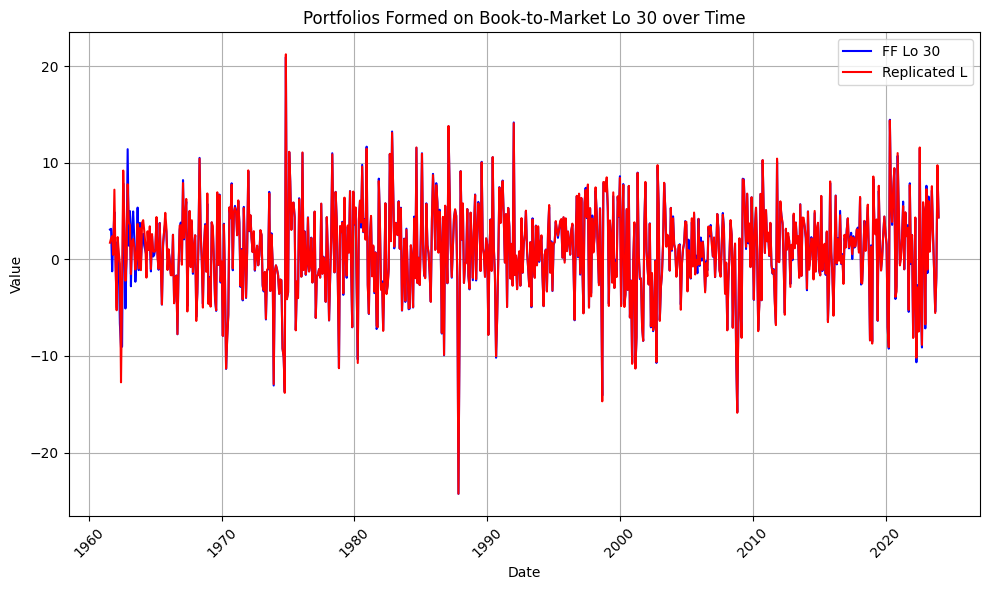

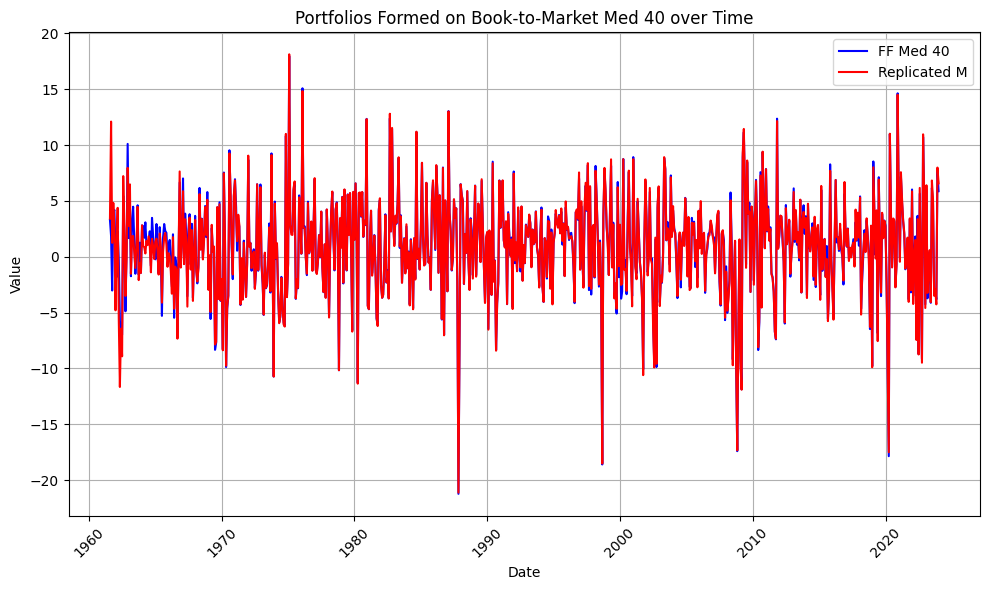

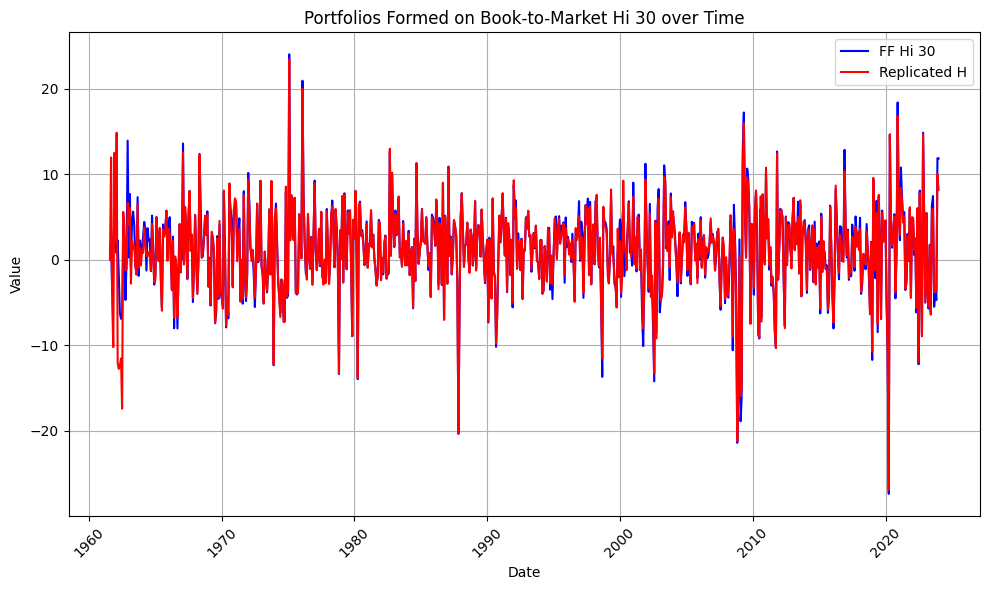

In [116]:
# value-weigthed return
vwret_bm=ccm4.groupby(['jdate','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret_bm'})

ff_factors_bm=vwret_bm.pivot(index='jdate', columns='bmport', values='vwret_bm').reset_index()
ff_factors_bm['year_month'] = ff_factors_bm['jdate'].dt.to_period('M')
#use data downloaded from Ken French’s website/Univariate sorts on Size, B/M, OP, and Inv/Portfolios Formed on Book-to-Market/Value Weight Returns -- Monthly
df_bm = pd.read_csv("Portfolios_Formed_on_BE-ME_CSV_3.csv")
#df['year_month'] = df['year'].dt.to_period('M')
df_bm['year_month'] = pd.to_datetime(df_bm['year'].astype(str), format='%Y%m')
df_bm['year_month'] = df_bm['year_month'].dt.to_period('M')
_ffcomp_bm = pd.merge(df_bm, ff_factors_bm[['jdate','year_month','H','M','L']], how='inner', on=['year_month'])
_ffcomp_bm['L']=_ffcomp_bm['L']*100
_ffcomp_bm['M']=_ffcomp_bm['M']*100
_ffcomp_bm['H']=_ffcomp_bm['H']*100
_ffcomp_bm=_ffcomp_bm.dropna()
_ffcomp_bm
plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_bm['jdate'], _ffcomp_bm['Lo 30'], color='blue', linestyle='-', label='FF Lo 30')
plt.plot(_ffcomp_bm['jdate'], _ffcomp_bm['L'], color='red', linestyle='-', label='Replicated L')
plt.title('Portfolios Formed on Book-to-Market Lo 30 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_bm['jdate'], _ffcomp_bm['Med 40'], color='blue', linestyle='-', label='FF Med 40')
plt.plot(_ffcomp_bm['jdate'], _ffcomp_bm['M'], color='red', linestyle='-', label='Replicated M')
plt.title('Portfolios Formed on Book-to-Market Med 40 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_bm['jdate'], _ffcomp_bm['Hi 30'], color='blue', linestyle='-', label='FF Hi 30')
plt.plot(_ffcomp_bm['jdate'], _ffcomp_bm['H'], color='red', linestyle='-', label='Replicated H')
plt.title('Portfolios Formed on Book-to-Market Hi 30 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

In [117]:
print(stats.pearsonr(_ffcomp_bm['Lo 30'], _ffcomp_bm['L']))
print(stats.pearsonr(_ffcomp_bm['Med 40'], _ffcomp_bm['M']))
print(stats.pearsonr(_ffcomp_bm['Hi 30'], _ffcomp_bm['H']))

PearsonRResult(statistic=0.9936168400459335, pvalue=0.0)
PearsonRResult(statistic=0.9874922416202506, pvalue=0.0)
PearsonRResult(statistic=0.9585677811222396, pvalue=0.0)


Calculate scores

In [126]:
import pandas as pd
import numpy as np

yours = _ffcomp_bm['L']
ff = _ffcomp_bm['Lo 30']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_L = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Book-to-Market Lo 30:  {score_L}")


yours = _ffcomp_bm['M']
ff = _ffcomp_bm['Med 40']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_M = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Book-to-Market Med 40:  {score_M}")

yours = _ffcomp_bm['H']
ff = _ffcomp_bm['Hi 30']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_H = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Book-to-Market Hi 30:  {score_H}")

# Compute the average score
average_score = (score_L + score_M + score_H) / 3
print(f"Average Score: {average_score}")


Score for Book-to-Market Lo 30:  99.23669316550038
Score for Book-to-Market Med 40:  96.95092584773919
Score for Book-to-Market Hi 30:  93.66173468643326
Average Score: 96.61645123322427


Compare Portfolios Formed on Operating Profitability

C:\Users\Minna\AppData\Local\Temp\ipykernel_17500\1017621279.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwret_pro=ccm4.groupby(['jdate','proport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret_pro'})


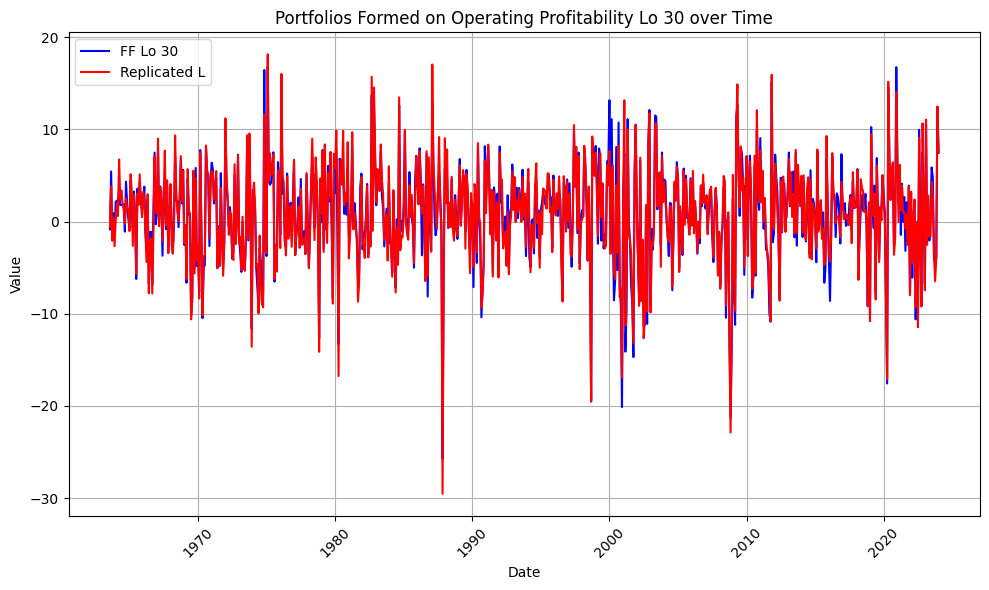

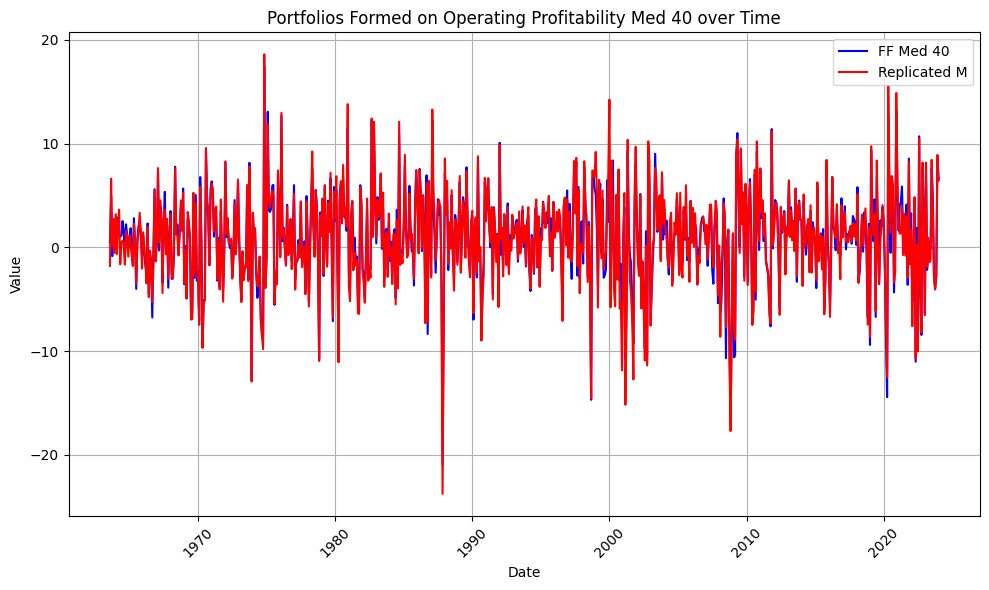

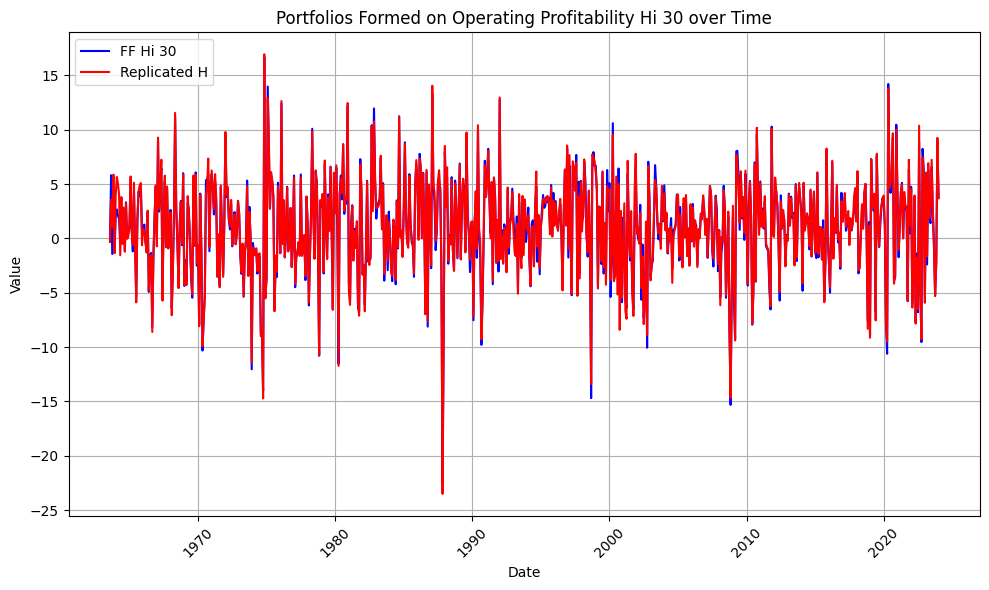

In [119]:
# value-weigthed return

vwret_pro=ccm4.groupby(['jdate','proport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret_pro'})

ff_factors_pro=vwret_pro.pivot(index='jdate', columns='proport', values='vwret_pro').reset_index()
ff_factors_pro
ff_factors_pro['year_month'] = ff_factors_pro['jdate'].dt.to_period('M')

#use data downloaded from Ken French’s website/Univariate sorts on Size, B/M, OP, and Inv/Portfolios Formed on Operating Profitability/Value Weight Returns -- Monthly
df_pro = pd.read_csv("Portfolios_Formed_on_OP_CSV_3.csv")

df_pro['year_month'] = pd.to_datetime(df_pro['year'].astype(str), format='%Y%m')
df_pro['year_month'] = df_pro['year_month'].dt.to_period('M')
_ffcomp_pro = pd.merge(df_pro, ff_factors_pro[['jdate','year_month','H','M','L']], how='inner', on=['year_month'])
_ffcomp_pro['L']=_ffcomp_pro['L']*100
_ffcomp_pro['M']=_ffcomp_pro['M']*100
_ffcomp_pro['H']=_ffcomp_pro['H']*100
_ffcomp_pro=_ffcomp_pro.dropna()

#draw the picture
plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_pro['jdate'], _ffcomp_pro['Lo 30'], color='blue', linestyle='-', label='FF Lo 30')
plt.plot(_ffcomp_pro['jdate'], _ffcomp_pro['L'], color='red', linestyle='-', label='Replicated L')
plt.title('Portfolios Formed on Operating Profitability Lo 30 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_pro['jdate'], _ffcomp_pro['Med 40'], color='blue', linestyle='-', label='FF Med 40')
plt.plot(_ffcomp_pro['jdate'], _ffcomp_pro['M'], color='red', linestyle='-', label='Replicated M')
plt.title('Portfolios Formed on Operating Profitability Med 40 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_pro['jdate'], _ffcomp_pro['Hi 30'], color='blue', linestyle='-', label='FF Hi 30')
plt.plot(_ffcomp_pro['jdate'], _ffcomp_pro['H'], color='red', linestyle='-', label='Replicated H')
plt.title('Portfolios Formed on Operating Profitability Hi 30 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

In [120]:
print(stats.pearsonr(_ffcomp_pro['Lo 30'], _ffcomp_pro['L']))
print(stats.pearsonr(_ffcomp_pro['Med 40'], _ffcomp_pro['M']))
print(stats.pearsonr(_ffcomp_pro['Hi 30'], _ffcomp_pro['H']))

PearsonRResult(statistic=0.9654148545539039, pvalue=0.0)
PearsonRResult(statistic=0.9711962398944275, pvalue=0.0)
PearsonRResult(statistic=0.9898639193962863, pvalue=0.0)


Calculate scores

In [127]:
import pandas as pd
import numpy as np

yours = _ffcomp_pro['L']
ff = _ffcomp_pro['Lo 30']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_L = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Operating Profitability Lo 30:  {score_L}")


yours = _ffcomp_pro['M']
ff = _ffcomp_pro['Med 40']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_M = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Operating Profitability Med 40:  {score_M}")

yours = _ffcomp_pro['H']
ff = _ffcomp_pro['Hi 30']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_H = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Operating Profitability Hi 30:  {score_H}")

# Compute the average score
average_score = (score_L + score_M + score_H) / 3
print(f"Average Score: {average_score}")


Score for Operating Profitability Lo 30:  94.02574270410904
Score for Operating Profitability Med 40:  89.46519074376725
Score for Operating Profitability Hi 30:  97.68210563734533
Average Score: 93.72434636174053


Compare Portfolios Formed on Investment 

C:\Users\Minna\AppData\Local\Temp\ipykernel_17500\1219207392.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwret_inv=ccm4.groupby(['jdate','invport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret_inv'})


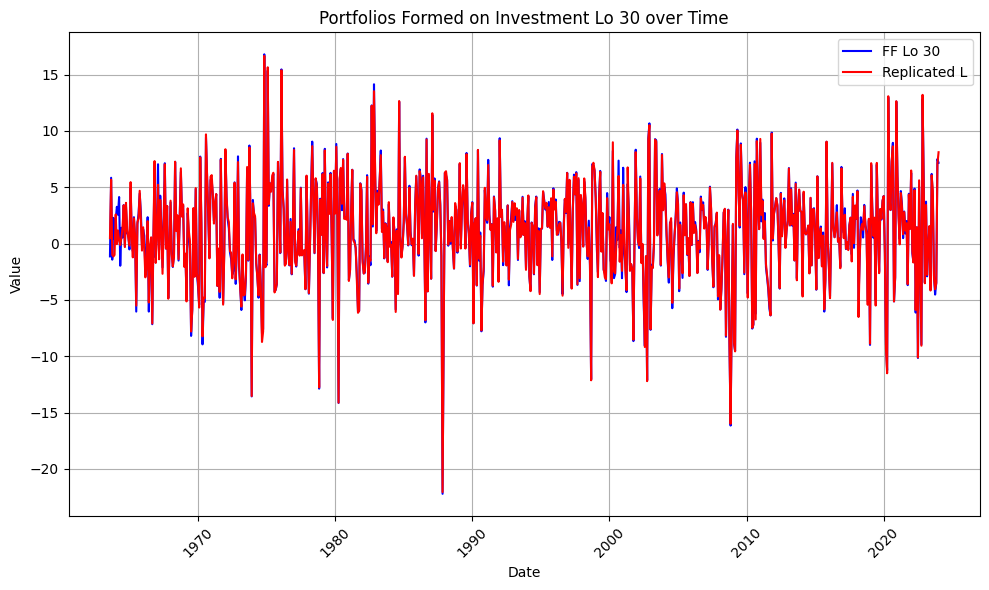

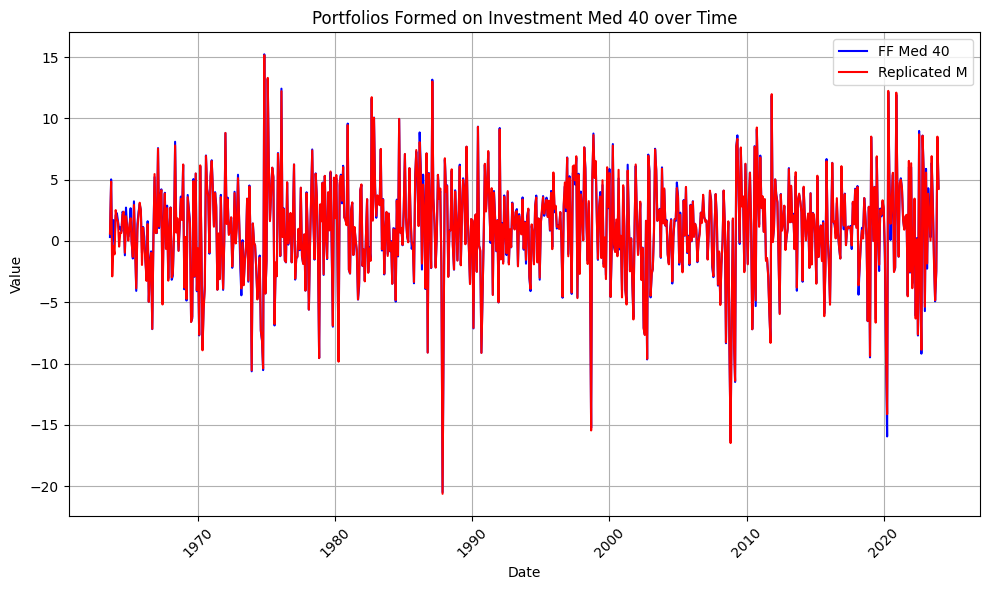

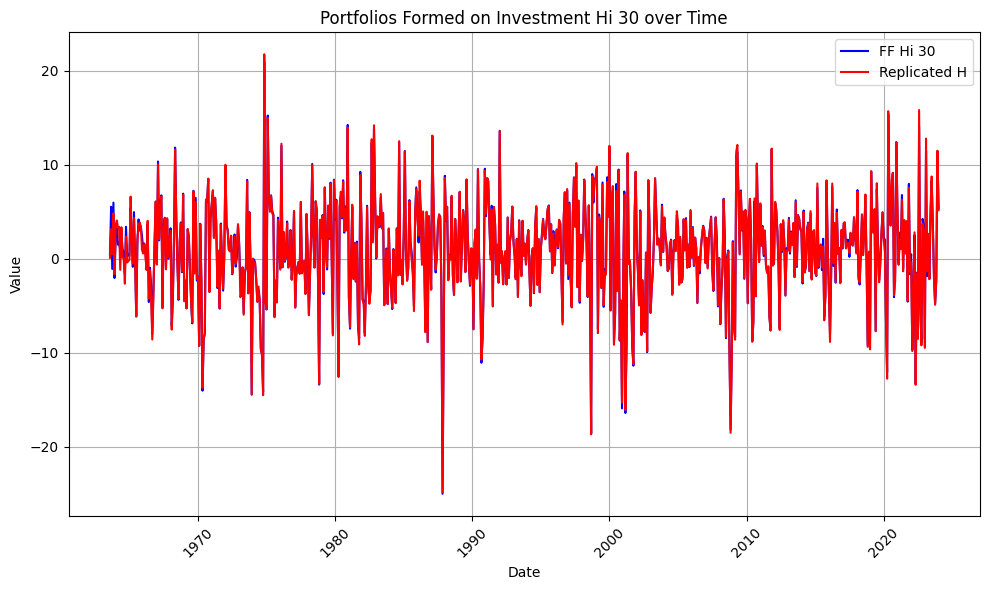

In [122]:
# value-weigthed return

vwret_inv=ccm4.groupby(['jdate','invport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret_inv'})

ff_factors_inv=vwret_inv.pivot(index='jdate', columns='invport', values='vwret_inv').reset_index()
ff_factors_inv
ff_factors_inv['year_month'] = ff_factors_inv['jdate'].dt.to_period('M')

#use data downloaded from Ken French’s website/Univariate sorts on Size, B/M, OP, and Inv/Portfolios Formed on Investment/Value Weight Returns -- Monthly
df_inv = pd.read_csv("Portfolios_Formed_on_INV_CSV_3.csv")

df_inv['year_month'] = pd.to_datetime(df_inv['year'].astype(str), format='%Y%m')
df_inv['year_month'] = df_inv['year_month'].dt.to_period('M')
_ffcomp_inv = pd.merge(df_inv, ff_factors_inv[['jdate','year_month','H','M','L']], how='inner', on=['year_month'])
_ffcomp_inv['L']=_ffcomp_inv['L']*100
_ffcomp_inv['M']=_ffcomp_inv['M']*100
_ffcomp_inv['H']=_ffcomp_inv['H']*100
_ffcomp_inv=_ffcomp_inv.dropna()

#draw the picture
plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_inv['jdate'], _ffcomp_inv['Lo 30'], color='blue', linestyle='-', label='FF Lo 30')
plt.plot(_ffcomp_inv['jdate'], _ffcomp_inv['L'], color='red', linestyle='-', label='Replicated L')
plt.title('Portfolios Formed on Investment Lo 30 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_inv['jdate'], _ffcomp_inv['Med 40'], color='blue', linestyle='-', label='FF Med 40')
plt.plot(_ffcomp_inv['jdate'], _ffcomp_inv['M'], color='red', linestyle='-', label='Replicated M')
plt.title('Portfolios Formed on Investment Med 40 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(_ffcomp_inv['jdate'], _ffcomp_inv['Hi 30'], color='blue', linestyle='-', label='FF Hi 30')
plt.plot(_ffcomp_inv['jdate'], _ffcomp_inv['H'], color='red', linestyle='-', label='Replicated H')
plt.title('Portfolios Formed on Investment Hi 30 over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
print(stats.pearsonr(_ffcomp_inv['Lo 30'], _ffcomp_inv['L']))
print(stats.pearsonr(_ffcomp_inv['Med 40'], _ffcomp_inv['M']))
print(stats.pearsonr(_ffcomp_inv['Hi 30'], _ffcomp_inv['H']))

PearsonRResult(statistic=0.9959267331601898, pvalue=0.0)
PearsonRResult(statistic=0.9981886856382127, pvalue=0.0)
PearsonRResult(statistic=0.9978937344168494, pvalue=0.0)


Calculate scores

In [128]:
import pandas as pd
import numpy as np

yours = _ffcomp_inv['L']
ff = _ffcomp_inv['Lo 30']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_L = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Investment  Lo 30:  {score_L}")


yours = _ffcomp_inv['M']
ff = _ffcomp_inv['Med 40']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_M = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Investment  Med 40:  {score_M}")

yours = _ffcomp_inv['H']
ff = _ffcomp_inv['Hi 30']
# Compute correlation
corr = yours.corr(ff)
# Compute mean differences
mu_yours = yours.mean()
mu_ff = ff.mean()
# Compute standard deviation differences
sigma_yours = yours.std()
sigma_ff = ff.std()
# Compute the final score
score_H = 50 * corr + 25 * (1 - abs(mu_yours - mu_ff)) + 25 * (1 - abs(sigma_yours - sigma_ff))
print(f"Score for Investment  Hi 30:  {score_H}")

# Compute the average score
average_score = (score_L + score_M + score_H) / 3
print(f"Average Score: {average_score}")


Score for Investment  Lo 30:  98.47409837389128
Score for Investment  Med 40:  99.27273242224933
Score for Investment  Hi 30:  98.0993453953047
Average Score: 98.6153920638151
